# Long Short Term memory and other Neural Networks

In [14]:
import duckdb
import pandas as pd
import pandas_ta as ta
import os
import csv
import itertools


def trail_stoploss(row, tradingdata, whole_percentage):
    idx = row.name
    td = tradingdata
    pct = whole_percentage/100
    max_holdtime = 30 # Only hold the trade for twenty minutes

    after_td = td.loc[idx:idx+max_holdtime+1]

    basis = td['close'].loc[idx]
    max_price = basis   # Initially the max price is the basis - No Shorting to Start
    min_price = basis - (basis*pct)
    time_stop = idx + max_holdtime
    time_counter = idx

    #print(f"Basis: {basis}")

    for i, row in after_td.iterrows():
        close = row['close']
        #print(f"Close: {close}, Max: {max_price}, Min: {min_price}, Counter: {time_counter-idx}")
        if close > max_price:
            max_price = close
            min_price = max_price - (max_price * pct)
        elif close < min_price:
            profit = (close - basis) / basis
            return [i, profit]

        time_counter += 1
        if time_counter > time_stop:
            break

    # If the loop ends without triggering stop loss, calculate the profit based on the last close
    profit = (close - basis) / basis
    return profit

con = duckdb.connect(r"C:\Users\rybot\OneDrive\Databases\datadump.duckdb")

# Filter data for January to March 2022
start_date = '2022-01-01'
end_date = '2022-12-31'
ticker = 'AAPL'

qry_month = f'''
    SELECT * FROM Stocks
    WHERE Datetime >= '{start_date}' 
    AND Datetime < '{end_date}' 
    AND Stock = '{ticker}' 
    AND Interval = 1
'''
df = con.execute(qry_month).fetchdf()
# Sort the Data from oldest to newest
df = df.sort_values(by='Datetime').reset_index(drop=True)

# Getting all of the trading days because trades can only occur during trading day
df['Time'] = df['Datetime'].dt.time
start_time = pd.to_datetime('09:00:00').time()
end_time = pd.to_datetime('16:00:00').time()
TradingDay_df = df[(df['Time'] > start_time) & (df['Time'] < end_time) & (df.index >= 201)]

df['Profit'] = TradingDay_df.apply(trail_stoploss, axis=1, tradingdata=df,whole_percentage=5)

#applying EMAs SMAs
EMAs = [8,10,20,50,75,100]
SMAs = [8,10,20,50,75,100]

for EMA in EMAs:
    df[f'EMA{EMA}'] = ta.ema(df['close'], length=EMA)
    df[f'EMA{EMA}_pct'] = df[f'EMA{EMA}'].pct_change()
    df = df.drop([f'EMA{EMA}'],axis=1).copy()

for SMA in SMAs:
    df[f'SMA{SMA}'] = ta.sma(df['close'], length=SMA)
    df[f'SMA{SMA}_pct'] = df[f'SMA{SMA}'].pct_change()
    df = df.drop([f'SMA{SMA}'],axis=1).copy()

# 1st (pct chg)
df['dydx'] = df['close'].pct_change()

# 2nd
df['dydx2'] = df['dydx'].pct_change()

df = df.drop(['Datetime','open','high','low','close','volume','Stock','interval','Time'], axis=1)
print(df.info())

df1 = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204969 entries, 0 to 204968
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Profit      105084 non-null  float64
 1   EMA8_pct    204961 non-null  float64
 2   EMA10_pct   204959 non-null  float64
 3   EMA20_pct   204949 non-null  float64
 4   EMA50_pct   204919 non-null  float64
 5   EMA75_pct   204894 non-null  float64
 6   EMA100_pct  204869 non-null  float64
 7   SMA8_pct    204961 non-null  float64
 8   SMA10_pct   204959 non-null  float64
 9   SMA20_pct   204949 non-null  float64
 10  SMA50_pct   204919 non-null  float64
 11  SMA75_pct   204894 non-null  float64
 12  SMA100_pct  204869 non-null  float64
 13  dydx        204968 non-null  float32
 14  dydx2       201920 non-null  float32
dtypes: float32(2), float64(13)
memory usage: 21.9 MB
None


In [16]:
from sklearn.preprocessing import MinMaxScaler
#df = df.drop(['Datetime','open','high','low','close','volume','Stock','interval','Time'], axis=1)
import numpy as np

df = df1.copy()

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

min_max_scaler = MinMaxScaler()

# Select the columns you want to normalize (all except 'Profit' if it's the target)
columns_to_scale = df.columns.drop(['Profit'])

# Fit the scaler on the selected columns and transform the data
df[columns_to_scale] = min_max_scaler.fit_transform(df[columns_to_scale])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
print(df.info())



# with pd.ExcelWriter('output.xlsx',engine='xlsxwriter') as writer:
  #  df.to_excel(writer, sheet_name="Sheet1")

<class 'pandas.core.frame.DataFrame'>
Index: 102812 entries, 237 to 204782
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Profit      102812 non-null  float64
 1   EMA8_pct    102812 non-null  float64
 2   EMA10_pct   102812 non-null  float64
 3   EMA20_pct   102812 non-null  float64
 4   EMA50_pct   102812 non-null  float64
 5   EMA75_pct   102812 non-null  float64
 6   EMA100_pct  102812 non-null  float64
 7   SMA8_pct    102812 non-null  float64
 8   SMA10_pct   102812 non-null  float64
 9   SMA20_pct   102812 non-null  float64
 10  SMA50_pct   102812 non-null  float64
 11  SMA75_pct   102812 non-null  float64
 12  SMA100_pct  102812 non-null  float64
 13  dydx        102812 non-null  float64
 14  dydx2       102812 non-null  float64
dtypes: float64(15)
memory usage: 12.6 MB
None


# Pytrorch CNN

### 1. Prepare Your Data
- In order to make the data in the correct format, you first need to packet the data
  - This is not the same as previous attempts as the data is not flattened, but instead keeps its shape for the CNN
  - The end result is a LoLoL which is a list of lists of lists [List of arrays consisting of lists], where the arrays are the packets, and the lists inside the arrays are the rows

- Expected output:

      array([[[A, B],
              [1, 2],
              [3, 3]],
             [[C, D],
              [3, 3],
              [4, 4]],


- Steps:
  1. Packet the data
  2. Turn it into a np array
  3. Turn it into a tensor
  4. Unsqueeze the tensor (format it for CNNs)

In [17]:
import torch
import numpy as np

# Packet the data
Packets = []
packet_size = 20

for i in range(packet_size, len(df)+1):
    snapshot = df.iloc[i-3:i].values
    Packets.append(snapshot)

# Convert to tensor and reshape
packets_tensor = torch.tensor(Packets).float()
packets_tensor = packets_tensor.unsqueeze(1)
print(packets_tensor.shape)

torch.Size([102793, 1, 3, 15])


# Lenet CNN Model
https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/

torch.Size([25020, 1, 3, 15])
Packets tensor shape: torch.Size([25020, 1, 3, 15])
Target tensor shape: torch.Size([25020])
[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.000179, Val loss: 0.000018

[INFO] EPOCH: 2/10
Train loss: 0.000014, Val loss: 0.000011

[INFO] EPOCH: 3/10
Train loss: 0.000011, Val loss: 0.000010

[INFO] EPOCH: 4/10
Train loss: 0.000011, Val loss: 0.000010

[INFO] EPOCH: 5/10
Train loss: 0.000010, Val loss: 0.000010

[INFO] EPOCH: 6/10
Train loss: 0.000010, Val loss: 0.000010

[INFO] EPOCH: 7/10
Train loss: 0.000010, Val loss: 0.000009

[INFO] EPOCH: 8/10
Train loss: 0.000010, Val loss: 0.000009

[INFO] EPOCH: 9/10
Train loss: 0.000010, Val loss: 0.000009

[INFO] EPOCH: 10/10
Train loss: 0.000010, Val loss: 0.000009

[INFO] Total training time: 38.95 seconds


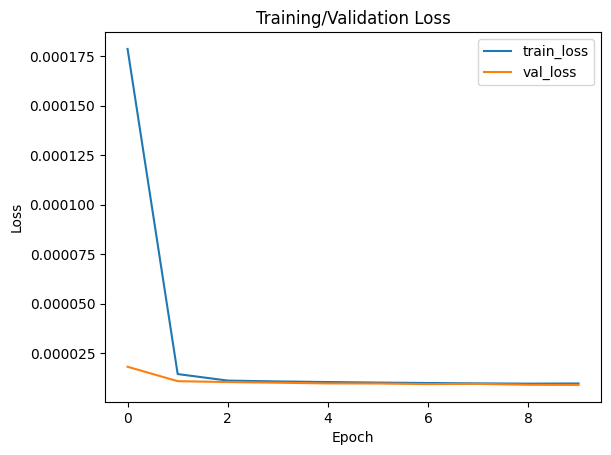

In [17]:
import torch
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, MSELoss
from torch import flatten
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import time
import numpy as np

# Packet the data
Packets = []
packet_size = 20

for i in range(packet_size, len(df)+1):
    snapshot = df.iloc[i-3:i].values
    Packets.append(snapshot)

# Convert to tensor and reshape
packets_tensor = torch.tensor(Packets).float()
packets_tensor = packets_tensor.unsqueeze(1)
print(packets_tensor.shape)

# Define the CNN Model
class LeNetTabular(Module):
    def __init__(self, numChannels):
        super(LeNetTabular, self).__init__()
        # First CONV => RELU => POOL layer
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=16, kernel_size=(1, 2))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        # Second CONV => RELU => POOL layer
        self.conv2 = Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 2))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        # Fully connected layers
        self.fc1 = Linear(in_features=32 * 1 * 11, out_features=50)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=50, out_features=1)  # Predicting "Profit"

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Hyperparameters
INIT_LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 10
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
# Assume df is your dataframe with 25517 rows
# You already have `packets_tensor` (shape: [25517, 1, 3, 15]) created from df
# The 'Profit' column is the target column
target_tensor = torch.tensor(df['Profit'].values).float()
target_tensor = target_tensor[:packets_tensor.shape[0]]


print("Packets tensor shape:", packets_tensor.shape)
print("Target tensor shape:", target_tensor.shape)


# Create the TensorDataset and split into training/validation
dataset = TensorDataset(packets_tensor, target_tensor)
numTrainSamples = int(len(dataset) * TRAIN_SPLIT)
numValSamples = len(dataset) - numTrainSamples
trainData, valData = random_split(dataset, [numTrainSamples, numValSamples])

# DataLoaders for training and validation
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# Initialize model, loss function, and optimizer
model = LeNetTabular(numChannels=1).to(device)
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = MSELoss()

# Training Loop
H = {
    "train_loss": [],
    "val_loss": []
}

print("[INFO] training the network...")
startTime = time.time()

for e in range(EPOCHS):
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0

    # Training loop
    for (x, y) in trainDataLoader:
        (x, y) = (x.to(device), y.to(device))

        # Perform forward pass, compute loss, backward pass, and update weights
        pred = model(x)
        loss = lossFn(pred.squeeze(), y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Add the training loss
        totalTrainLoss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for (x, y) in valDataLoader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            valLoss = lossFn(pred.squeeze(), y)
            totalValLoss += valLoss.item()

    # Calculate the average losses for the epoch
    avgTrainLoss = totalTrainLoss / len(trainDataLoader)
    avgValLoss = totalValLoss / len(valDataLoader)

    # Save losses for plotting later
    H["train_loss"].append(avgTrainLoss)
    H["val_loss"].append(avgValLoss)

    # Print epoch info
    print(f"[INFO] EPOCH: {e+1}/{EPOCHS}")
    print(f"Train loss: {avgTrainLoss:.6f}, Val loss: {avgValLoss:.6f}\n")

# Final time
endTime = time.time()
print(f"[INFO] Total training time: {endTime - startTime:.2f} seconds")

# Plotting the training/validation loss curves
#plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()


# Code Review

In [12]:
import itertools
import torch
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, MSELoss
from torch import flatten
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import time
import numpy as np


# Define the hyperparameter grid
param_grid = {
    'lr': [1e-5, 1e-4, 1e-3],  # Learning rates to test
    'batch_size': [32, 64, 128],  # Batch sizes to test
    'conv1_out_channels': [16, 32],  # Number of filters in the first conv layer
    'conv2_out_channels': [32, 64],  # Number of filters in the second conv layer
    'epcoch':[10,20,30]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(param_grid['lr'], 
                                            param_grid['batch_size'], 
                                            param_grid['conv1_out_channels'], 
                                            param_grid['conv2_out_channels'],
                                            param_grid['epcoch']))

# Iterate through each combination
best_val_loss = float('inf')
best_params = None

TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in param_combinations:
    lr, batch_size, conv1_out_channels, conv2_out_channels, epcoch = params
    EPOCHS = epcoch
    print(f"Testing combination: lr={lr}, batch_size={batch_size}, conv1_out_channels={conv1_out_channels}, conv2_out_channels={conv2_out_channels}, epcoch={epcoch}")
    
    # Rebuild your model with the new hyperparameters
    class LeNetTabular(Module):
        def __init__(self, numChannels):
            super(LeNetTabular, self).__init__()
            self.conv1 = Conv2d(in_channels=numChannels, out_channels=conv1_out_channels, kernel_size=(1, 2))
            self.relu1 = ReLU()
            self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
            self.conv2 = Conv2d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(1, 2))
            self.relu2 = ReLU()
            self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
            self.fc1 = Linear(in_features=conv2_out_channels * 1 * 11, out_features=50)
            self.relu3 = ReLU()
            self.fc2 = Linear(in_features=50, out_features=1)  # Predicting "Profit"

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.maxpool1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.maxpool2(x)
            x = flatten(x, 1)
            x = self.fc1(x)
            x = self.relu3(x)
            x = self.fc2(x)
            return x

    # Initialize the model, loss function, optimizer
    model = LeNetTabular(numChannels=1).to(device)
    opt = Adam(model.parameters(), lr=lr)
    lossFn = MSELoss()

    # Packet the data
    Packets = []
    packet_size = 20

    for i in range(packet_size, len(df)+1):
        snapshot = df.iloc[i-3:i].values
        Packets.append(snapshot)

    # Convert to tensor and reshape
    packets_tensor = torch.tensor(Packets).float()
    packets_tensor = packets_tensor.unsqueeze(1)

    target_tensor = torch.tensor(df['Profit'].values).float()
    target_tensor = target_tensor[:packets_tensor.shape[0]]

    # Create the TensorDataset and split into training/validation
    dataset = TensorDataset(packets_tensor, target_tensor)
    numTrainSamples = int(len(dataset) * TRAIN_SPLIT)
    numValSamples = len(dataset) - numTrainSamples
    trainData, valData = random_split(dataset, [numTrainSamples, numValSamples])

    # Re-create DataLoaders with the new batch size
    trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
    valDataLoader = DataLoader(valData, batch_size=batch_size)

    # Training Loop (simplified)
    for e in range(EPOCHS):
        model.train()
        totalTrainLoss = 0
        totalValLoss = 0

        # Training loop
        for (x, y) in trainDataLoader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = lossFn(pred.squeeze(), y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            totalTrainLoss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for (x, y) in valDataLoader:
                (x, y) = (x.to(device), y.to(device))
                pred = model(x)
                valLoss = lossFn(pred.squeeze(), y)
                totalValLoss += valLoss.item()

        # Calculate the average losses for the epoch
        avgValLoss = totalValLoss / len(valDataLoader)

    # Check if current parameters result in a lower validation loss
    print("Avg Val Loss:", avgValLoss)
    if avgValLoss < best_val_loss:
        best_val_loss = avgValLoss
        best_params = params

print(f"Best parameters: {best_params} with validation loss {best_val_loss:.4f}") 

Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=16, conv2_out_channels=32, epcoch=10
Avg Val Loss: 1.171401857864483e-05
Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=16, conv2_out_channels=32, epcoch=20
Avg Val Loss: 9.24077995728576e-06
Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=16, conv2_out_channels=32, epcoch=30
Avg Val Loss: 9.243907880095414e-06
Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=16, conv2_out_channels=64, epcoch=10
Avg Val Loss: 9.64593703531359e-06
Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=16, conv2_out_channels=64, epcoch=20
Avg Val Loss: 8.855921972711685e-06
Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=16, conv2_out_channels=64, epcoch=30
Avg Val Loss: 8.582360096068219e-06
Testing combination: lr=1e-05, batch_size=32, conv1_out_channels=32, conv2_out_channels=32, epcoch=10
Avg Val Loss: 9.916658279266534e-06
Testing combination: lr=1e-05, batch

# CNN with the best Grid Search Parameters on all 2022 data

In [18]:
import itertools
import torch
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, MSELoss
from torch import flatten
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import time
import numpy as np


# Define the hyperparameter grid
param_grid = {
    'lr': [1e-3],  # Learning rates to test
    'batch_size': [128],  # Batch sizes to test
    'conv1_out_channels': [16],  # Number of filters in the first conv layer
    'conv2_out_channels': [32],  # Number of filters in the second conv layer
    'epcoch':[30]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(param_grid['lr'], 
                                            param_grid['batch_size'], 
                                            param_grid['conv1_out_channels'], 
                                            param_grid['conv2_out_channels'],
                                            param_grid['epcoch']))

# Iterate through each combination
best_val_loss = float('inf')
best_params = None

TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in param_combinations:
    lr, batch_size, conv1_out_channels, conv2_out_channels, epcoch = params
    EPOCHS = epcoch
    print(f"Testing combination: lr={lr}, batch_size={batch_size}, conv1_out_channels={conv1_out_channels}, conv2_out_channels={conv2_out_channels}, epcoch={epcoch}")
    
    # Rebuild your model with the new hyperparameters
    class LeNetTabular(Module):
        def __init__(self, numChannels):
            super(LeNetTabular, self).__init__()
            self.conv1 = Conv2d(in_channels=numChannels, out_channels=conv1_out_channels, kernel_size=(1, 2))
            self.relu1 = ReLU()
            self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
            self.conv2 = Conv2d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(1, 2))
            self.relu2 = ReLU()
            self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
            self.fc1 = Linear(in_features=conv2_out_channels * 1 * 11, out_features=50)
            self.relu3 = ReLU()
            self.fc2 = Linear(in_features=50, out_features=1)  # Predicting "Profit"

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.maxpool1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.maxpool2(x)
            x = flatten(x, 1)
            x = self.fc1(x)
            x = self.relu3(x)
            x = self.fc2(x)
            return x

    # Initialize the model, loss function, optimizer
    model = LeNetTabular(numChannels=1).to(device)
    opt = Adam(model.parameters(), lr=lr)
    lossFn = MSELoss()

    # Packet the data
    Packets = []
    packet_size = 20

    for i in range(packet_size, len(df)+1):
        snapshot = df.iloc[i-3:i].values
        Packets.append(snapshot)

    # Convert to tensor and reshape
    packets_tensor = torch.tensor(Packets).float()
    packets_tensor = packets_tensor.unsqueeze(1)

    target_tensor = torch.tensor(df['Profit'].values).float()
    target_tensor = target_tensor[:packets_tensor.shape[0]]

    # Create the TensorDataset and split into training/validation
    dataset = TensorDataset(packets_tensor, target_tensor)
    numTrainSamples = int(len(dataset) * TRAIN_SPLIT)
    numValSamples = len(dataset) - numTrainSamples
    trainData, valData = random_split(dataset, [numTrainSamples, numValSamples])

    # Re-create DataLoaders with the new batch size
    trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
    valDataLoader = DataLoader(valData, batch_size=batch_size)

    # Training Loop (simplified)
    for e in range(EPOCHS):
        model.train()
        totalTrainLoss = 0
        totalValLoss = 0

        # Training loop
        for (x, y) in trainDataLoader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = lossFn(pred.squeeze(), y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            totalTrainLoss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for (x, y) in valDataLoader:
                (x, y) = (x.to(device), y.to(device))
                pred = model(x)
                valLoss = lossFn(pred.squeeze(), y)
                totalValLoss += valLoss.item()

        # Calculate the average losses for the epoch
        avgValLoss = totalValLoss / len(valDataLoader)

    # Check if current parameters result in a lower validation loss
    print("Avg Val Loss:", avgValLoss)
    if avgValLoss < best_val_loss:
        best_val_loss = avgValLoss
        best_params = params

print(f"Best parameters: {best_params} with validation loss {best_val_loss:.4f}") 

Testing combination: lr=0.001, batch_size=128, conv1_out_channels=16, conv2_out_channels=32, epcoch=30
Avg Val Loss: 7.212800460478664e-06
Best parameters: (0.001, 128, 16, 32, 30) with validation loss 0.0000


In [21]:
TRAIN_SPLIT = 0.6  # 60% for training
VAL_SPLIT = 0.2    # 20% for validation
TEST_SPLIT = 0.2   # 20% for testing

numTrainSamples = int(len(dataset) * TRAIN_SPLIT)
numValSamples = int(len(dataset) * VAL_SPLIT)
numTestSamples = len(dataset) - numTrainSamples - numValSamples

trainData, valData, testData = random_split(dataset, [numTrainSamples, numValSamples, numTestSamples])

# Create DataLoaders for training, validation, and test sets
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
valDataLoader = DataLoader(valData, batch_size=batch_size)
testDataLoader = DataLoader(testData, batch_size=batch_size)


In [22]:
model.eval()
test_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for (x, y) in testDataLoader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = lossFn(pred.squeeze(), y)
        test_loss += loss.item()
        
        # Collect predictions and actual values for accuracy metrics
        all_preds.append(pred.squeeze().cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(testDataLoader)
print(f"Average Test Loss: {avg_test_loss:.6f}")

# Example accuracy metric: Mean Absolute Error (MAE)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
mae = np.mean(np.abs(all_preds - all_targets))
print(f"Mean Absolute Error: {mae:.6f}")

Average Test Loss: 0.000007
Mean Absolute Error: 0.001934


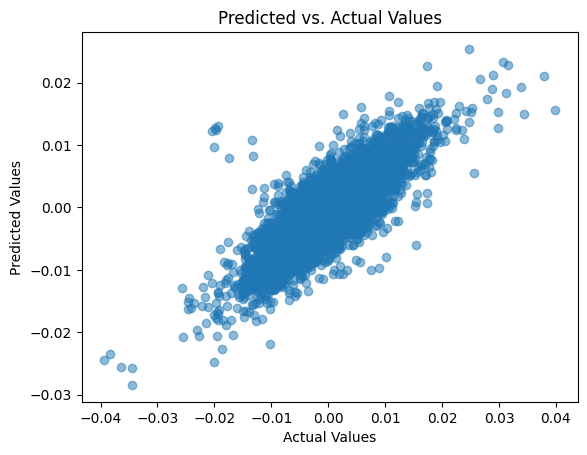

In [23]:
import matplotlib.pyplot as plt

plt.scatter(all_targets, all_preds, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()